# Air Pollution Data Analysis Project (Exploratory Data Analysis of Historical Pollutant Levels in New York City)

## 1.1 Introduction
This project delves into the analysis of historical air pollution data for New York City, focusing on key pollutants like CO, NO2, and PM2.5. The data is sourced from the OpenWeatherMap API [1], a rich repository that offers detailed records on air quality across different geographies. 

The motivation for this project stems from the increasing awareness and concern regarding urban air quality and its impact on public health and environmental sustainability. By examining trends and patterns in air pollution, this analysis aims to provide actionable insights that could inform policy decisions and public health strategies in urban settings.

## 1.2 Aims and Objectives
**Aims**:
- To identify long-term trends and seasonal variations in air pollution within New York City.
- To evaluate the impact of various pollutants on urban air quality and deduce potential underlying causes.

**Objectives**:
- To familiarize with the OpenWeatherMap API for fetching historical air pollution data.
- To process and clean the data to ensure it is suitable for detailed analysis.
- To conduct exploratory data analysis (EDA) to uncover patterns and anomalies in the data.
- To use statistical methods and visualizations to illustrate the findings, focusing on:
  - The correlation between different pollutants.
  - Seasonal trends in pollution levels.
  - Peaks in pollution and their possible correlation with external events.
  
## 1.3 Steps of the Project
The project will proceed through the following steps:

1. **Data Collection**: Use the OpenWeatherMap API to retrieve historical air pollution data for New York City.
2. **Data Cleaning and Preparation**: Ensure the data is consistent, handling any missing or anomalous data points.
3. **Exploratory Data Analysis (EDA)**: Conduct analysis to understand and draw insights from the data.
4. **Conclusions**: Draw conclusions from the analysis and outline recommendations for improving air quality based on the data.

## 1.4 Dataset

The dataset includes detailed air quality measurements taken from the (OpenWeatherMap API)[https://openweathermap.org/api], encompassing:
- Daily measurements of pollutants such as CO, NO2, O3, PM2.5, and PM10.
- Auxiliary data like timestamps and geo-coordinates which assist in detailed temporal and spatial analysis.

Specifically, we will look at the interval from November 27 2020 to April 30 2024.

## 1.5 Notes
All custom functions referenced are defined in the `utils.py` module. This module contains utility functions that support data fetching, processing, and analysis tasks for our projects.

In [1]:
import requests
import os
from dotenv import load_dotenv
import json
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("whitegrid")
import warnings
# Ignore FutureWarnings
#warnings.filterwarnings('ignore', category=FutureWarning)

import utils

# First we need to set the api key so we can access the api
load_dotenv()
api_key = os.getenv("WEATHER_API_KEY")

# Collecting Data with OpenWeatherMap API


### Get NYC Coordinates

Before we can begin fetching the air pollution data of New York City, we first need to retrieve the city's coordinates. This is because the API uses these coordinates as an argument as to gather data from that geographical area. We can retrieve these coordinates using the `fetch_city_coordinates` function.

In [2]:
city_coordinates = utils.fetch_city_coordinates(api_key, city="New York City")

lat = city_coordinates[0]['lat']
lon = city_coordinates[0]['lon']

print("NYC Latitude:", lat)
print("NYC Longitude:", lon)

NYC Latitude: 40.7127281
NYC Longitude: -74.0060152


### Get UNIX start and end time

To retrieve the appropriate historical data, we also need to specify a specific time interval, which the API expects to be a UNIX timestamp. Since we are interested in the time interval from November 27 2020 to April 30 2024, let's convert these dates from ISO 8601 to UNIX

In [3]:
unix_start = int(pd.Timestamp('2020-11-27').timestamp())
unix_end = int(pd.Timestamp('2024-04-30').timestamp())

print("UNIX timestamp for November 27, 2020:", unix_start)
print("UNIX timestamp for April 30, 2024:", unix_end)

UNIX timestamp for November 27, 2020: 1606435200
UNIX timestamp for April 30, 2024: 1714435200


### Get Air Pollution Data

Now that we have the city coordinates and the UNIX timestamp, we can use these arguments to gather air pollution history data from the API. We will do this using the `fetch_air_pollution_data` function.

In [4]:
air_pollution_data = utils.fetch_air_pollution_data(api_key, lat, lon, unix_start, unix_end)
pollution_df = pd.DataFrame(air_pollution_data['list'])
pollution_df

,main,components,dt
0,{'aqi': 2},"{'co': 680.92, 'no': 56.33, 'no2': 40.44, 'o3'...",1606435200
1,{'aqi': 2},"{'co': 734.33, 'no': 62.59, 'no2': 38.73, 'o3'...",1606438800
2,{'aqi': 2},"{'co': 727.65, 'no': 59.01, 'no2': 37.7, 'o3':...",1606442400
3,{'aqi': 2},"{'co': 667.57, 'no': 47.39, 'no2': 37.01, 'o3'...",1606446000
4,{'aqi': 2},"{'co': 647.54, 'no': 44.7, 'no2': 37.01, 'o3':...",1606449600
...,...,...,...
29684,{'aqi': 2},"{'co': 307.08, 'no': 2.35, 'no2': 19.54, 'o3':...",1714420800
29685,{'aqi': 2},"{'co': 347.14, 'no': 3.35, 'no2': 29.13, 'o3':...",1714424400
29686,{'aqi': 2},"{'co': 527.38, 'no': 7.49, 'no2': 65.12, 'o3':...",1714428000
29687,{'aqi': 3},"{'co': 761.03, 'no': 8.27, 'no2': 109.67, 'o3'...",1714431600


# Data Cleaning and Preparation

Once we've acquired the data, it's crucial to clean and prepare it for analysis. This process includes renaming column names for clarity, converting data types, and structuring the data in a way that facilitates easy analysis—paving the way for a seamless exploration.

### Check for empty values

In [5]:
pollution_df.isnull().any()

main          False
components    False
dt            False
dtype: bool

In [6]:
pollution_df.dtypes

main          object
components    object
dt             int64
dtype: object

### Break down "components" column into multiple columns

Notice how, instead of each pollutant having its own column, all the pollutants are put together in one dictionary within the "components" column. Similiarly, the air quality index information is put into a column called "main". Let's clean this up by breaking down the "components" column into seperate columns for each pollutant and reorganizing the "main" column into showing the air quality index value directly

In [7]:
# Clean up 'main' column so it directly shows Air Quality Index
pollution_df['Air Quality Index'] = pollution_df['main'].apply(lambda x: x['aqi'])
pollution_df = pollution_df.drop('main', axis=1)
pollution_df

,components,dt,Air Quality Index
0,"{'co': 680.92, 'no': 56.33, 'no2': 40.44, 'o3'...",1606435200,2
1,"{'co': 734.33, 'no': 62.59, 'no2': 38.73, 'o3'...",1606438800,2
2,"{'co': 727.65, 'no': 59.01, 'no2': 37.7, 'o3':...",1606442400,2
3,"{'co': 667.57, 'no': 47.39, 'no2': 37.01, 'o3'...",1606446000,2
4,"{'co': 647.54, 'no': 44.7, 'no2': 37.01, 'o3':...",1606449600,2
...,...,...,...
29684,"{'co': 307.08, 'no': 2.35, 'no2': 19.54, 'o3':...",1714420800,2
29685,"{'co': 347.14, 'no': 3.35, 'no2': 29.13, 'o3':...",1714424400,2
29686,"{'co': 527.38, 'no': 7.49, 'no2': 65.12, 'o3':...",1714428000,2
29687,"{'co': 761.03, 'no': 8.27, 'no2': 109.67, 'o3'...",1714431600,3


In [8]:
# Clean up 'components' column so each pollutant has their own column 
components_df = pollution_df['components'].apply(pd.Series)
pollution_df = pd.concat([pollution_df.drop('components', axis=1), components_df], axis=1)
pollution_df

,dt,Air Quality Index,co,no,no2,o3,so2,pm2_5,pm10,nh3
0,1606435200,2,680.92,56.33,40.44,0.00,6.14,15.29,23.04,2.28
1,1606438800,2,734.33,62.59,38.73,0.00,5.31,18.50,27.86,2.44
2,1606442400,2,727.65,59.01,37.70,0.00,4.59,19.94,30.20,2.31
3,1606446000,2,667.57,47.39,37.01,0.00,4.05,19.17,29.51,2.22
4,1606449600,2,647.54,44.70,37.01,0.00,3.67,19.01,28.97,2.06
...,...,...,...,...,...,...,...,...,...,...
29684,1714420800,2,307.08,2.35,19.54,86.55,6.20,5.99,7.21,1.38
29685,1714424400,2,347.14,3.35,29.13,77.25,8.34,6.73,8.59,1.85
29686,1714428000,2,527.38,7.49,65.12,60.08,15.50,16.49,21.16,3.74
29687,1714431600,3,761.03,8.27,109.67,42.92,19.79,35.34,43.04,5.45


### Convert UNIX timestamp to datetime

Currently, the dt column shows the timestamp in UNIX. This is a little confusing to read and interpret, so let's convert this to datetime instead.

In [9]:
pollution_df['dt'] = pd.to_datetime(pollution_df['dt'], unit='s')
pollution_df

,dt,Air Quality Index,co,no,no2,o3,so2,pm2_5,pm10,nh3
0,2020-11-27 00:00:00,2,680.92,56.33,40.44,0.00,6.14,15.29,23.04,2.28
1,2020-11-27 01:00:00,2,734.33,62.59,38.73,0.00,5.31,18.50,27.86,2.44
2,2020-11-27 02:00:00,2,727.65,59.01,37.70,0.00,4.59,19.94,30.20,2.31
3,2020-11-27 03:00:00,2,667.57,47.39,37.01,0.00,4.05,19.17,29.51,2.22
4,2020-11-27 04:00:00,2,647.54,44.70,37.01,0.00,3.67,19.01,28.97,2.06
...,...,...,...,...,...,...,...,...,...,...
29684,2024-04-29 20:00:00,2,307.08,2.35,19.54,86.55,6.20,5.99,7.21,1.38
29685,2024-04-29 21:00:00,2,347.14,3.35,29.13,77.25,8.34,6.73,8.59,1.85
29686,2024-04-29 22:00:00,2,527.38,7.49,65.12,60.08,15.50,16.49,21.16,3.74
29687,2024-04-29 23:00:00,3,761.03,8.27,109.67,42.92,19.79,35.34,43.04,5.45


### Rename columns for clarity

Finally, let's rename the column names of the dataframe to be clearer and easier to interpret

In [10]:
new_column_names = ['DateTime', 'Air Quality Index', 'CO Concentration', 'NO Concentration', 'NO2 Concentration',
                    'O3 Concentration', 'SO2 Concentration', 'PM2_5 Concentration', 'PM10 Concentration', 'NH3 Concentration']

pollution_df.columns = new_column_names
pollution_df

,DateTime,Air Quality Index,CO Concentration,NO Concentration,NO2 Concentration,O3 Concentration,SO2 Concentration,PM2_5 Concentration,PM10 Concentration,NH3 Concentration
0,2020-11-27 00:00:00,2,680.92,56.33,40.44,0.00,6.14,15.29,23.04,2.28
1,2020-11-27 01:00:00,2,734.33,62.59,38.73,0.00,5.31,18.50,27.86,2.44
2,2020-11-27 02:00:00,2,727.65,59.01,37.70,0.00,4.59,19.94,30.20,2.31
3,2020-11-27 03:00:00,2,667.57,47.39,37.01,0.00,4.05,19.17,29.51,2.22
4,2020-11-27 04:00:00,2,647.54,44.70,37.01,0.00,3.67,19.01,28.97,2.06
...,...,...,...,...,...,...,...,...,...,...
29684,2024-04-29 20:00:00,2,307.08,2.35,19.54,86.55,6.20,5.99,7.21,1.38
29685,2024-04-29 21:00:00,2,347.14,3.35,29.13,77.25,8.34,6.73,8.59,1.85
29686,2024-04-29 22:00:00,2,527.38,7.49,65.12,60.08,15.50,16.49,21.16,3.74
29687,2024-04-29 23:00:00,3,761.03,8.27,109.67,42.92,19.79,35.34,43.04,5.45


# Exploratory Data Analysis 

With our data cleaned and prepared, we move onto exploratory data analysis (EDA). We will focus our analysis on investigating the following questions:

- What are the mean concentrations of each pollutants?
- How do these concentrations do compare to one another; in other words what is the ratio between pollutant concentrations?
- What are the distributions of pollutant levels?
- How have each of these pollutant levels changed over time?
- How has the total concentration of pollutants in the air changed over time?
- What is the correlation between different pollutant levels?
- What are the long-term trends in pollution levels for each pollutant?
- Are there specific times of the year when pollution levels are consistently higher or lower?
- Are there any unusual spikes in pollution data? What might be causing these anomalies?

In [11]:
# Let's use the describe method to display statistical summaries 

pollution_df.describe()

,DateTime,Air Quality Index,CO Concentration,NO Concentration,NO2 Concentration,O3 Concentration,SO2 Concentration,PM2_5 Concentration,PM10 Concentration,NH3 Concentration
count,29689,29689.000000,29689.000000,29689.000000,29689.000000,29689.000000,29689.000000,29689.000000,29689.000000,29689.000000
mean,2022-08-13 05:51:51.819192064,2.176833,519.611521,23.010277,41.159648,41.120312,9.003004,17.617159,22.578907,2.799797
min,2020-11-27 00:00:00,1.000000,178.580000,0.000000,2.310000,-9999.000000,1.040000,0.500000,-9999.000000,0.010000
25%,2021-10-03 06:00:00,1.000000,310.420000,0.190000,20.390000,4.510000,4.890000,4.460000,6.410000,1.010000
50%,2022-08-12 12:00:00,2.000000,387.190000,2.600000,35.300000,33.980000,7.330000,9.820000,13.610000,1.730000
75%,2023-06-23 18:00:00,3.000000,547.410000,17.210000,56.210000,62.940000,10.970000,19.990000,25.970000,3.070000
max,2024-04-30 00:00:00,5.000000,5500.790000,729.560000,271.440000,457.760000,101.090000,368.430000,430.840000,65.860000
std,NaN,1.146410,405.269592,55.160425,27.043426,72.288381,6.516993,24.990237,65.838400,3.749845


### Mean Concentrations

Let's examine the mean concentration of each pollutant and compare them in a bar chart. We can see that some gasses, like NH3 and SO2, have relatively lower mean concentrations, while CO has a much higher mean concentration, taking a disproportionately large share.

In [12]:
# Store Mean Levels
mean_values = pollution_df.drop(['DateTime', 'Air Quality Index'], axis=1, errors='ignore').describe().loc['mean'].round(2)
pollutant_means = {
    'CO (µg/m³)': mean_values['CO Concentration'],
    'NO (µg/m³)': mean_values['NO Concentration'],
    'NO2 (µg/m³)': mean_values['NO2 Concentration'],
    'O3 (µg/m³)': mean_values['O3 Concentration'],
    'SO2 (µg/m³)': mean_values['SO2 Concentration'],
    'PM2.5 (µg/m³)': mean_values['PM2_5 Concentration'],
    'PM10 (µg/m³)': mean_values['PM10 Concentration'],
    'NH3 (µg/m³)': mean_values['NH3 Concentration']
}

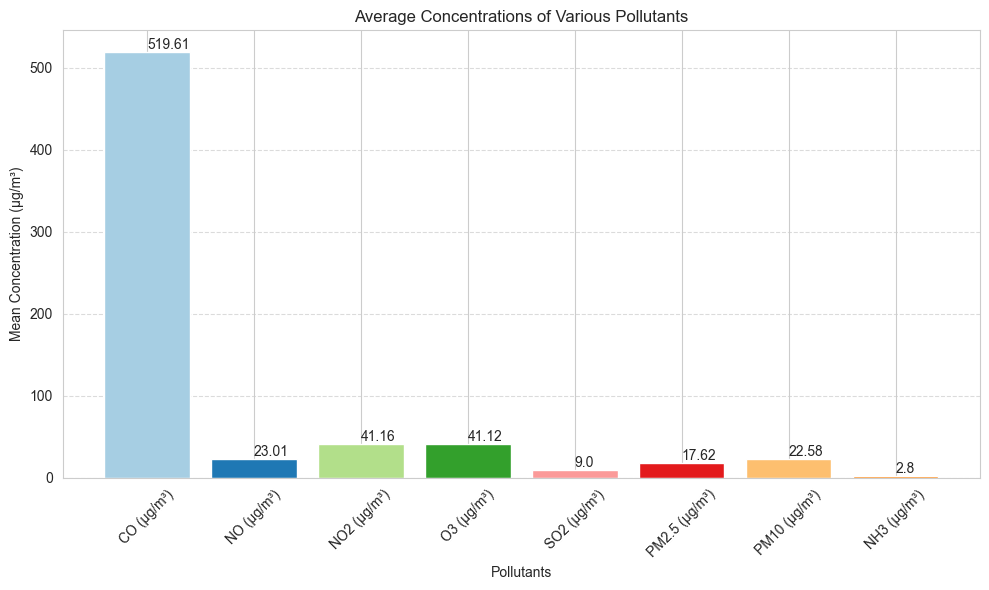

In [13]:
# Plot Mean Levels
df_means = pd.DataFrame(list(pollutant_means.items()), columns=['Pollutant', 'Mean Concentration'])

plt.figure(figsize=(10, 6))
colors = plt.cm.Paired(range(len(df_means)))  # Ensure there are enough colors for all bars
bars = plt.bar(df_means['Pollutant'], df_means['Mean Concentration'], color=colors)

plt.title('Average Concentrations of Various Pollutants')
plt.xlabel('Pollutants')
plt.ylabel('Mean Concentration (µg/m³)')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)

for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval, round(yval, 2), va='bottom') 

plt.tight_layout()
plt.show()

### Pollutant Ratios

We can already see that the concentration of Carbon Monoxide is much greater than that of the other gasses, but it would be interesting to see the exact percentages and visualize the ratios. We can illustrate this using a pie chart.

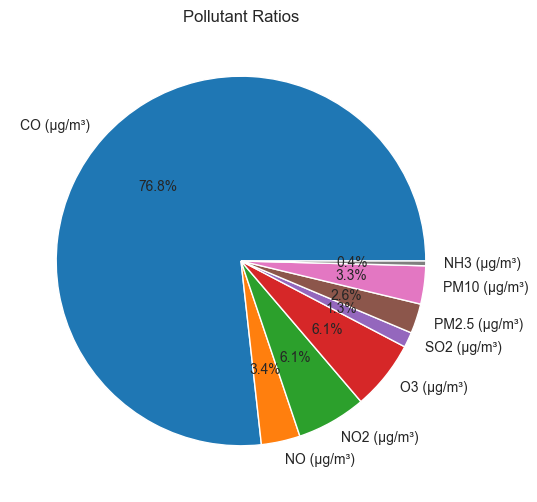

In [14]:
plt.figure(figsize=(6,6))
plt.pie(df_means['Mean Concentration'], labels=df_means['Pollutant'], autopct='%1.1f%%')
plt.title('Pollutant Ratios')
plt.show()

### Distribution of Pollutant Levels
Although we can visualize how the mean levels of each concentration compare to one other, this does not tell us much about the overall data and whether each pollutant concentration tends to stay close to its mean or fluctuates between different levels. We can investigate this by plotting the appropriate distributions.

We see that most of the distributions are right skewed, indicating that there are likely many days with extremely high pollutant concentrations. Aditionally, we see that the levels fluctuate more for some pollutants compared to others. For example, NO2 has a relatively wide spread, indicating that pollutant levels tend to fluctuate, while NO has a narrow spread, indicating that 

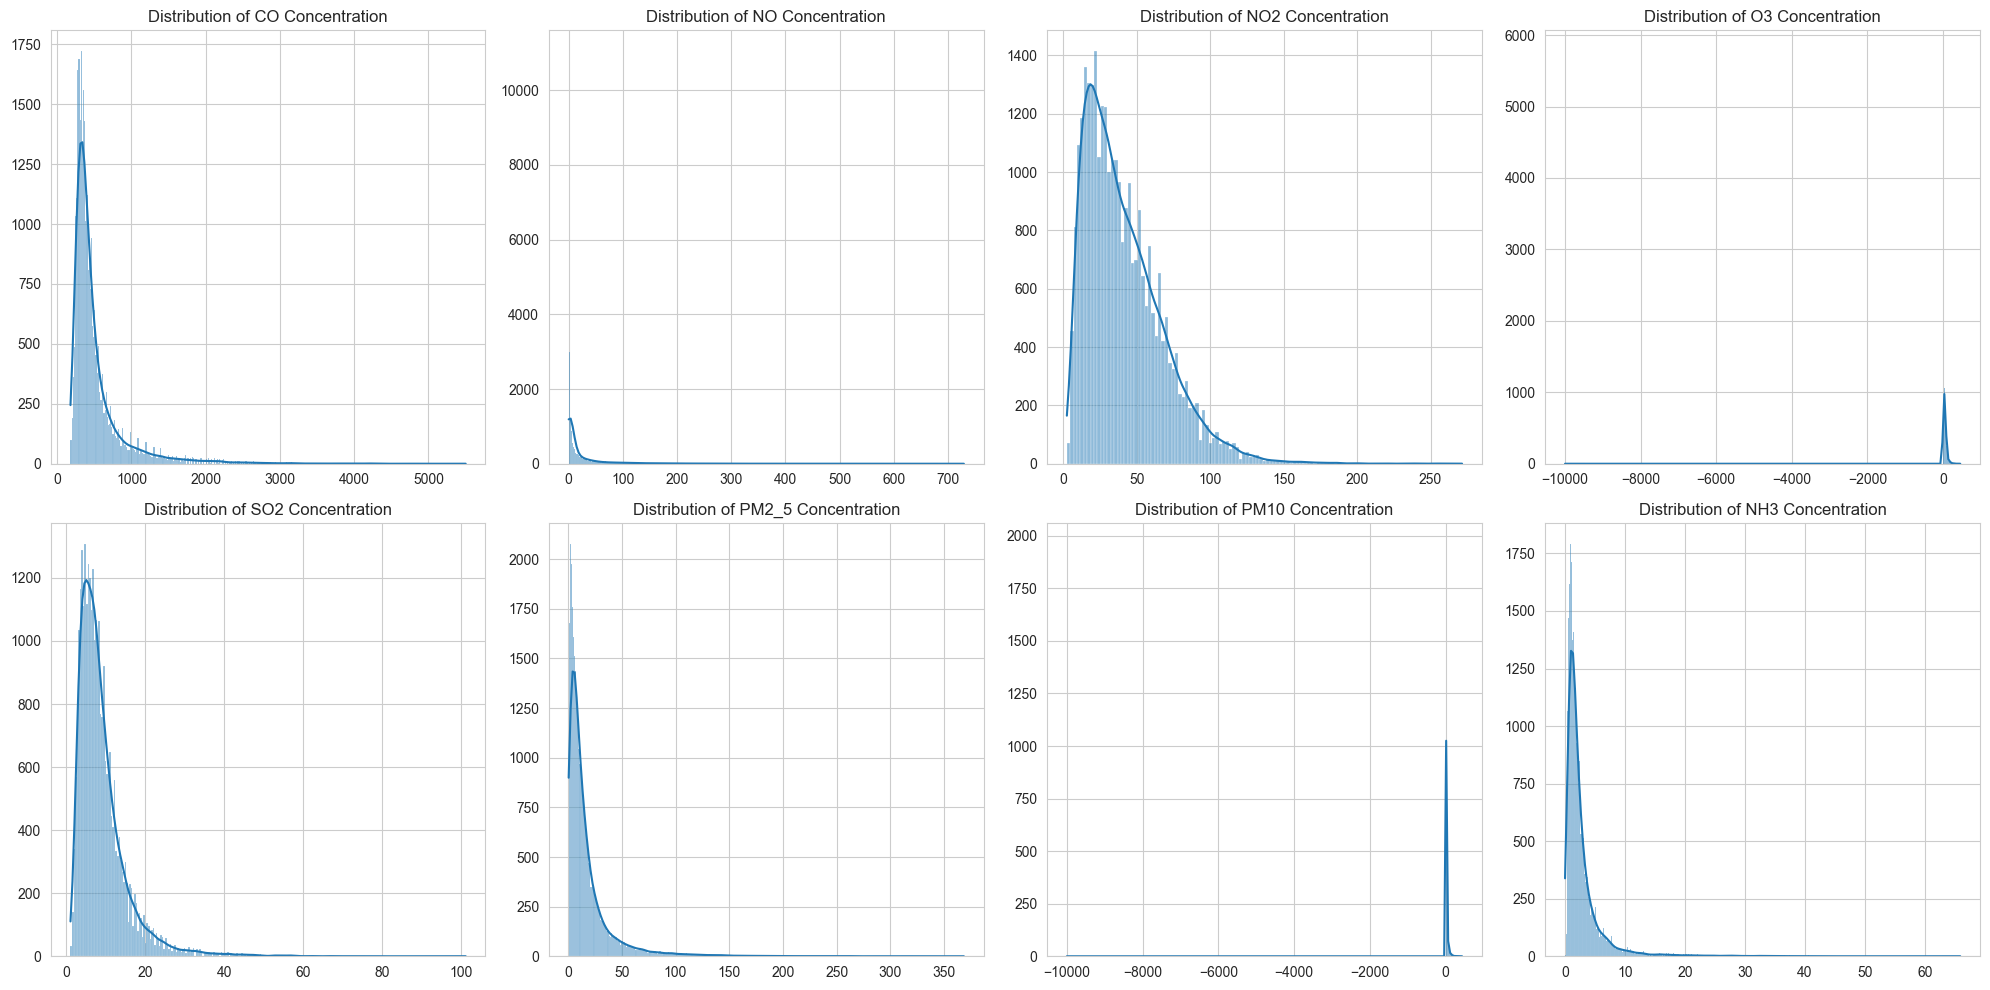

In [128]:
pollutants = ['CO Concentration', 'NO Concentration', 
              'NO2 Concentration', 'O3 Concentration', 'SO2 Concentration', 
              'PM2_5 Concentration', 'PM10 Concentration', 'NH3 Concentration']

fig, axes = plt.subplots(2, 4, figsize=(20, 10))
axes = axes.flatten()

for i, pollutant in enumerate(pollutants):
    sns.histplot(pollution_df[pollutant], kde=True, ax=axes[i])
    axes[i].set_title(f'Distribution of {pollutant}')
    axes[i].set_xlabel('')
    axes[i].set_ylabel('')
    
plt.tight_layout()

plt.show()

### Pollutant Levels over time

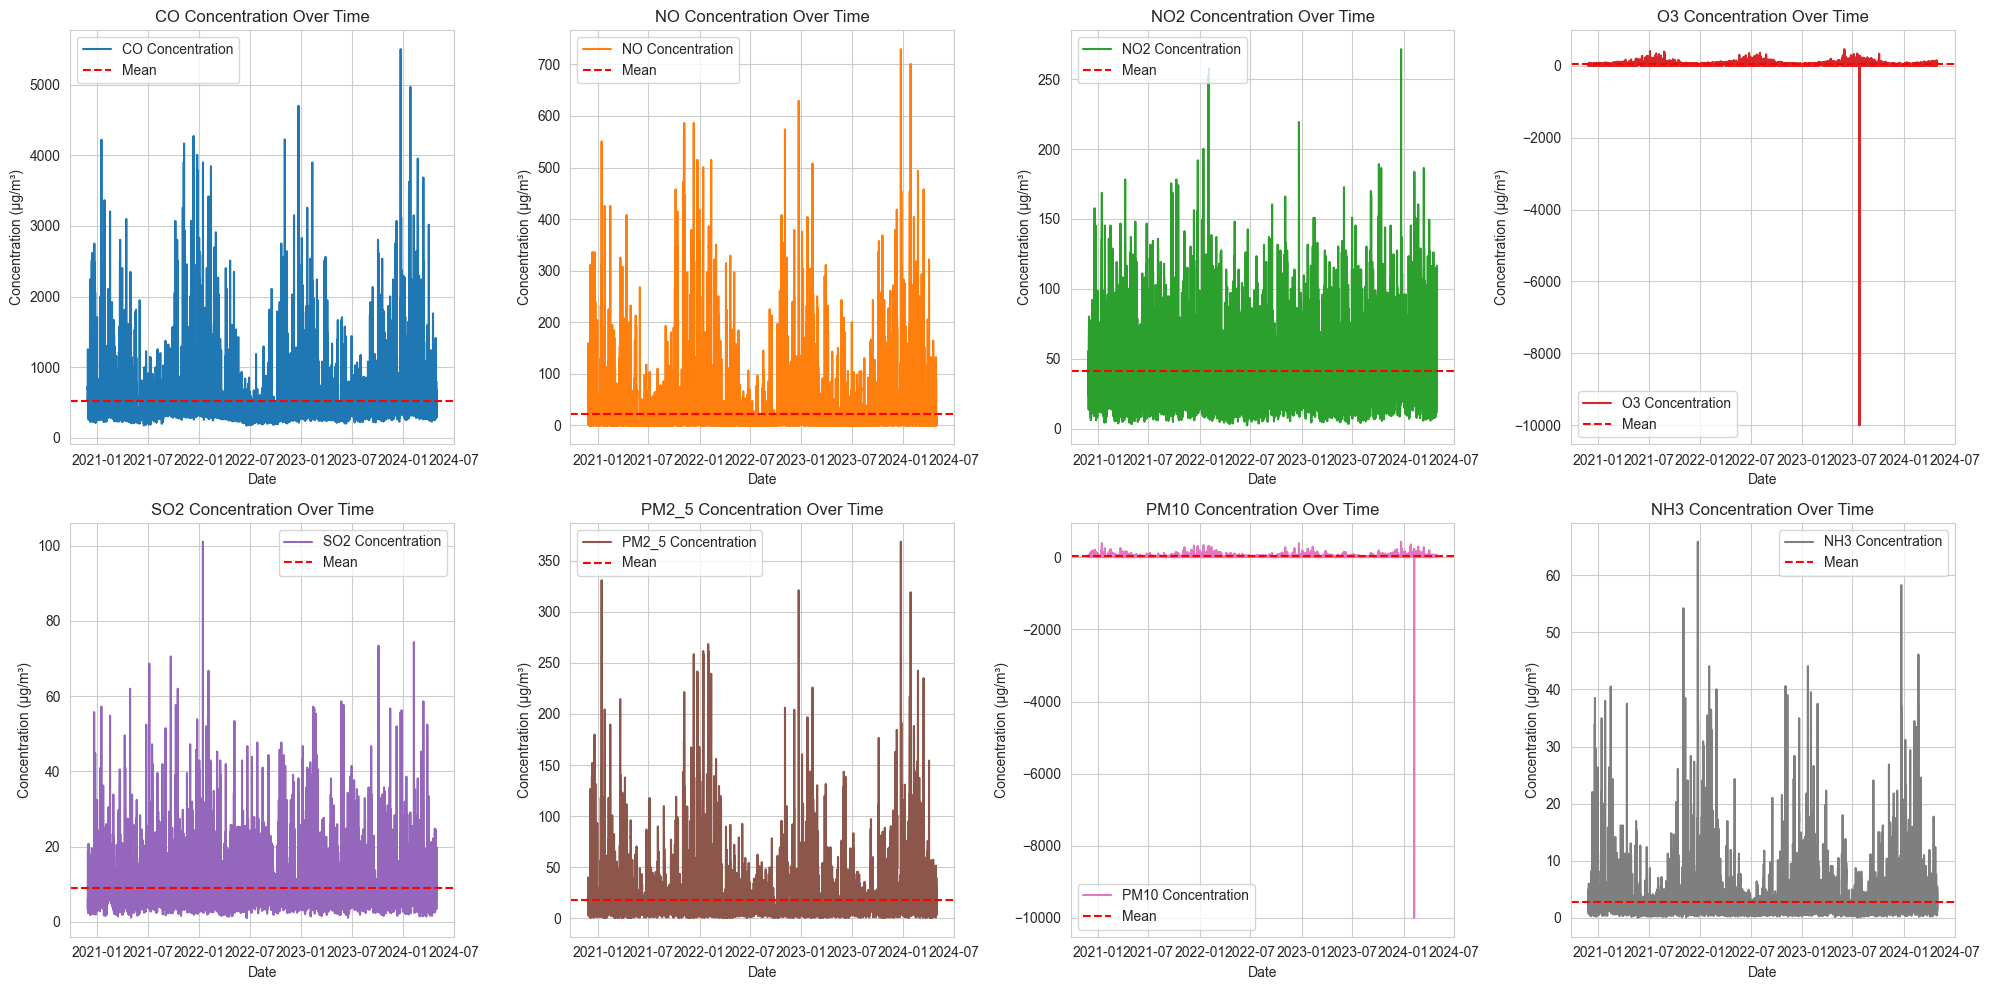

In [21]:
import matplotlib.pyplot as plt
import seaborn as sns

pollutants = {
    'CO Concentration': 'CO Concentration',
    'NO Concentration': 'NO Concentration',
    'NO2 Concentration': 'NO2 Concentration',
    'O3 Concentration': 'O3 Concentration',
    'SO2 Concentration': 'SO2 Concentration',
    'PM2_5 Concentration': 'PM2_5 Concentration',
    'PM10 Concentration': 'PM10 Concentration',
    'NH3 Concentration': 'NH3 Concentration'
}

fig, axes = plt.subplots(2, 4, figsize=(20, 10))
axes = axes.flatten()  

for i, (name, column) in enumerate(pollutants.items()):
    axes[i].plot(pollution_df['DateTime'], pollution_df[column], label=f'{name}', color=sns.color_palette("tab10")[i])
    axes[i].axhline(y=pollution_df[column].mean(), color='red', linestyle='--', label='Mean')
    axes[i].set_title(f'{name} Over Time')
    axes[i].set_xlabel('Date')
    axes[i].set_ylabel('Concentration (µg/m³)')
    axes[i].legend()
    axes[i].grid(True)

plt.tight_layout()

plt.show()

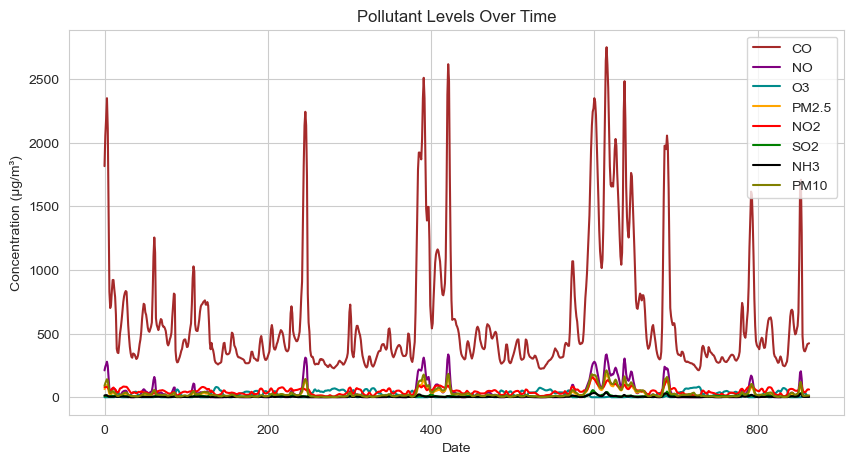

In [48]:
# Graph levels of all pollutants in one graph

plt.figure(figsize=(10, 5))

plt.plot(df.index, df['CO Concentration'], linestyle='-', color='brown', label='CO')
plt.plot(df.index, df['NO Concentration'], linestyle='-', color='purple', label='NO')
plt.plot(df.index, df['O3 Concentration'], linestyle='-', color='darkcyan', label='O3')
plt.plot(df.index, df['PM2_5 Concentration'], linestyle='-', color='orange', label='PM2.5')
plt.plot(df.index, df['NO2 Concentration'], linestyle='-', color='red', label='NO2')
plt.plot(df.index, df['SO2 Concentration'], linestyle='-', color='green', label='SO2')
plt.plot(df.index, df['NH3 Concentration'], linestyle='-', color='black', label='NH3')
plt.plot(df.index, df['PM10 Concentration'], linestyle='-', color='olive', label='PM10')

plt.title('Pollutant Levels Over Time')
plt.xlabel('Date')
plt.ylabel('Concentration (µg/m³)')

plt.legend()

plt.grid(True)

plt.show()

### Total Pollutant Concentration over time

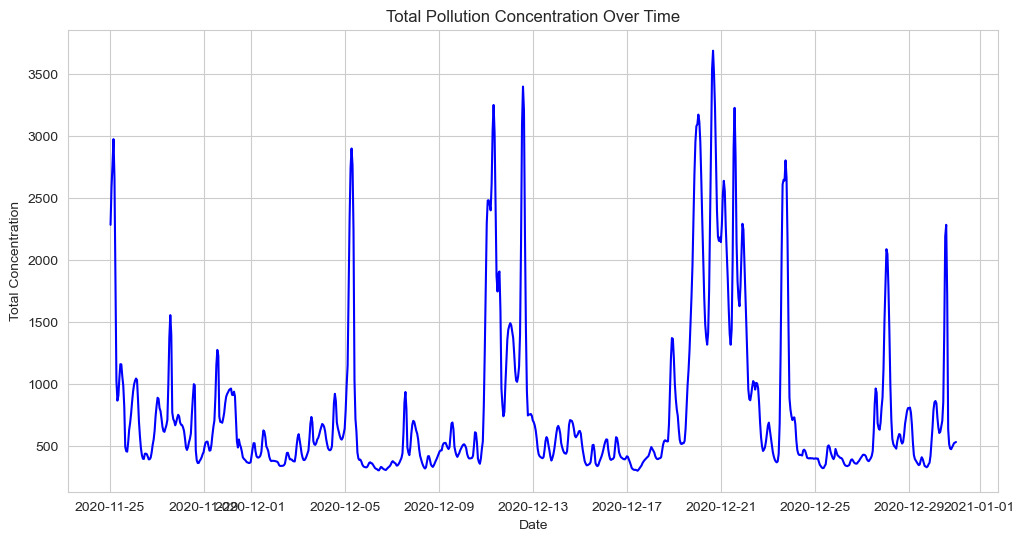

In [49]:
# Let's also look at the levels of total concentration of all the pollutants combined

concentration_sum = df[['NO Concentration', 'CO Concentration', 'O3 Concentration', 'PM2_5 Concentration', 
                        'NO2 Concentration', 'SO2 Concentration', 'NH3 Concentration', 'PM10 Concentration']].sum(axis=1)

df['total_concentration'] = concentration_sum

df.set_index('DateTime', inplace=True)

plt.figure(figsize=(12, 6))
plt.plot(df.index, df['total_concentration'], linestyle='-', color='blue')
plt.title('Total Pollution Concentration Over Time')
plt.xlabel('Date')
plt.ylabel('Total Concentration')
plt.grid(True)
plt.show()

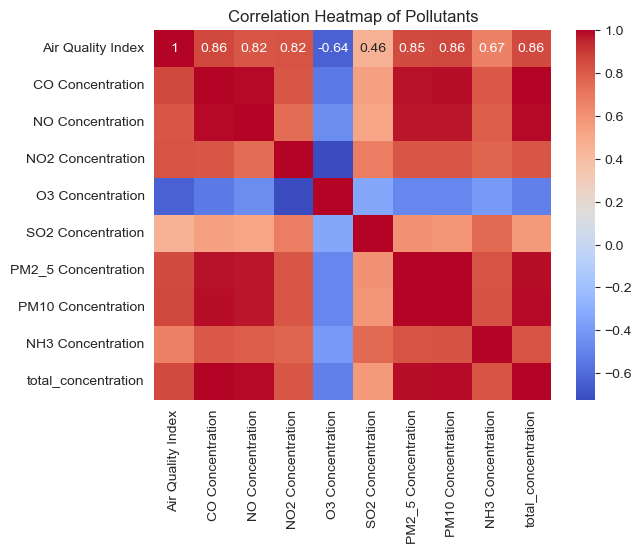

In [50]:
#Finally, we can create a heatmap to illustrate correlations between different pollutant levels.

sns.heatmap(df.corr(), annot=True, cmap='coolwarm')
plt.title('Correlation Heatmap of Pollutants')
plt.show()

## Trend Analysis

Building on our exploratory data analysis, we now focus on identifying long-term trends in the data. This involves using statistical methods and time-series analysis techniques to detect whether pollutants' levels are increasing, decreasing, or remaining stable over time.

First, in the code below let's explore whether there is a discrepancy of average pollutant concentration between seasons. In other words, do some seasons have higher levels of pollutants than others?

In [61]:
df.head()

,Air Quality Index,CO Concentration,NO Concentration,NO2 Concentration,O3 Concentration,SO2 Concentration,PM2_5 Concentration,PM10 Concentration,NH3 Concentration,total_concentration
DateTime,,,,,,,,,,
2020-11-25 01:00:00,5,1815.80,211.00,79.51,0.0,7.87,63.81,90.35,14.06,2282.40
2020-11-25 02:00:00,5,2056.12,239.61,80.20,0.0,8.35,77.15,110.21,15.07,2586.71
2020-11-25 03:00:00,5,2189.64,257.49,79.51,0.0,8.94,86.94,126.06,16.47,2765.05
2020-11-25 04:00:00,5,2349.85,278.95,80.88,0.0,9.30,96.19,141.36,15.58,2972.11
2020-11-25 05:00:00,5,2109.53,246.76,76.08,0.0,7.99,83.11,129.25,9.12,2661.84


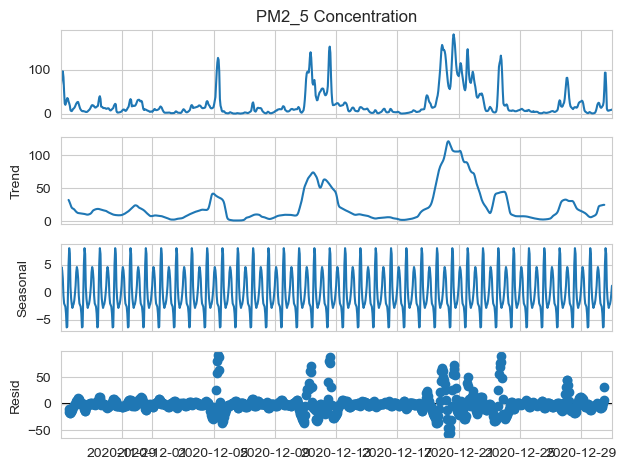

In [51]:
# Seasonal Decomposition - Let's investigate whether there is a discrepancy of average levels between 

from statsmodels.tsa.seasonal import seasonal_decompose

# Assuming your DataFrame `df` has a datetime index and a pollutant column
# Example for one pollutant:

for pollutant in pollutants:
result = seasonal_decompose(df['PM2_5 Concentration'], model='additive')
result.plot()
plt.show()



In [56]:
for pollutant in pollutants:
    print(pollutant)

Air Quality Index
CO Concentration
NO Concentration
NO2 Concentration
O3 Concentration
SO2 Concentration
PM2_5 Concentration
PM10 Concentration
